Finding a path through a maze is analogous to many common search problems in computer science. Why not literally find a path through a maze to illustrate the bfs, dfs and A* algorithms?

In [50]:
from enum import Enum
from typing import List, NamedTuple, Callable, Optional #, Generic
import random
from math import sqrt
from __future__ import annotations
#from generic_search import dfs, bfs, node_to_path, astar, Node

%run 01_generic_example.ipynb

The maze will be a two-dimensional grid of `Cells`. A `Cell` is an enum with `str` values where `" "` will represent an empty space and `"X"` will represent a blocked space.

In [51]:
class Cell(str, Enum):
    EMPTY = " "
    BLOCKED = "X"
    START = "S"
    GOAL = "G"
    PATH = "*"

We will need a way to an individual location in the maze. This will simply be a `NamedTuple` with properties representing the row and column of the location in question.

In [52]:
class MazeLocation(NamedTuple):
    row: int
    column: int

In [53]:
# foo = MazeLocation(1,2)

# print(foo)

MazeLocation(row=1, column=2)


In [1]:
foo.column

### Generating a random maze

The `Maze` class will internally keep track of a grid (a list of lists) representing its state. It will also have instance variables for the number of rows, number of columns, start location, and goal location. Its grid will be randomly filled with blocked cells. 

The generated maze should be fairly sparse so that there is almost always a path from a given starting location to a given goal location. We'll let the caller of a new maze decide on the exact sparseness, but we will provide a default value of 20% blocked. 

When a random number beats the threshold of the `sparseness` parameter in question, we will simply replace an empty space with a wall. If we do this for every possible place in the maze, statistically, the sparseness of the maze as a whole will approximate the `sparseness` parameter supplied.

In [55]:
class Maze:
    def __init__(self, rows: int = 10, columns: int = 10, sparseness: float = 0.2,
                 start: MazeLocation = MazeLocation(0, 0), goal: MazeLocation = MazeLocation(9,9)) -> None:
        # Initialize basic instance variables
        self._rows: int = rows
        self._columns: int = columns
        self.start: MazeLocation = start
        self.goal: MazeLocation = goal
        
        # fill the grid with empty cells
        self._grid: List[List[Cell]] = [[Cell.EMPTY for c in range(columns)] for r in range(rows)]
        # populate the grid with blocked cells
        self._randomly_fill(rows, columns, sparseness)
        # fill the start and goal locations in
        self._grid[start.row][start.column] = Cell.START
        self._grid[goal.row][goal.column] = Cell.GOAL
    
    def _randomly_fill(self, rows: int, columns: int, sparseness: float):
        for row in range(rows):
            for column in range(columns):                   #Genius!
                if random.uniform(0, 1.0) < sparseness:
                    self._grid[row][column] = Cell.BLOCKED
                    
    # Return a nicely formatted version of the maze for printing
    def __str__(self) -> str:
        output: str = ""
        for row in self._grid:
            output += "".join([c.value for c in row]) + "\n"
        return output
    
    # Checking if a particular MazeLocation has reached the goal
    def goal_test(self, ml: MazeLocation) -> bool:
        return ml == self.goal
    
    # How can we move within our maze?
    # The next function can find the possible next locations from a given MazeLocation
    # Since each maze is different, this function is defined within this class.
    def successors (self, ml: MazeLocation) -> List[MazeLocation]:
        locations: List[MazeLocation] = []
        if ml.row + 1 < self._rows and self._grid[ml.row + 1][ml.column] != Cell.BLOCKED:
            locations.append(MazeLocation(ml.row + 1, ml.column))
        if ml.row - 1 >= 0 and self._grid[ml.row - 1][ml.column] != Cell.BLOCKED:
            locations.append(MazeLocation(ml.row - 1, ml.column))
        if ml.column + 1 < self._columns and self._grid[ml.row][ml.column + 1] != Cell.BLOCKED:
            locations.append(MazeLocation(ml.row, ml.column + 1))
        if ml.column - 1 >= 0 and self._grid[ml.row][ml.column - 1] != Cell.BLOCKED:
            locations.append(MazeLocation(ml.row, ml.column - 1))
        return locations
    
    # For display purposes, it will be useful to mark up the maze with the successful path, 
    #the start date, and the goal state. It will also be useful to be able to remove a path so 
    #that we can try different search algorithms on the same maze. The following two methods 
    #are therefore added to the `Maze` class.
    def mark(self, path: List[MazeLocation]):
        for maze_location in path:
            self._grid[maze_location.row][maze_location.column] = Cell.PATH
        self._grid[self.start.row][self.start.column] = Cell.START
        self._grid[self.goal.row][self.goal.column] = Cell.GOAL
    
    def clear(self, path: List[MazeLocation]):
        for maze_location in path:
            self._grid[maze_location.row][maze_location.column] = Cell.EMPTY
        self._grid[self.start.row][self.start.column] = Cell.START
        self._grid[self.goal.row][self.goal.column] = Cell.GOAL

In [56]:
# # Testing...
# maze: Maze = Maze()
    
# print(maze)

SX        
   XX    X
   XX  X  
     X  X 
  X       
          
  X       
XX      X 
 X     X  
    XX X G



## Depth-first search

The depth-first search algorithm relies on a data structure known as a *stack*. A stack is a data structure that operates under the Last-In-First-Out (LIFO) principle. 

It is common for a stack to be implemented on top of a more primitive data structure like a list. We will implement our stack on top of Python's `list` type. 

Stacks generally have at least two operations:

- `push()` - Places an item on top of the stack
- `pop()` - Removes the item from the top of the stack and returns it.

We will implement both of these, as well as an `empty` property to check if the stack has any more items in it.

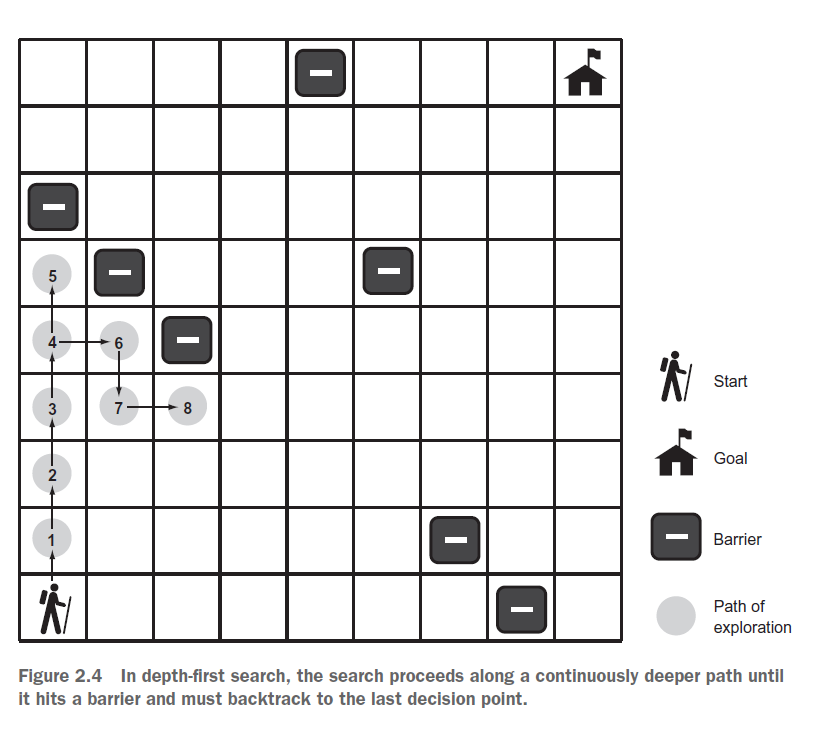

In [57]:
class Stack(Generic[T]):
    def __init__(self) -> None:
        self._container: List[T] = []
            
    @property  # Esto permite esto: Stack().empty
    def empty(self) -> bool:
        return not self._container  # not is true for empty container
    
    def push(self, item: T) -> None:
        self._container.append(item)
        
    def pop(self) -> T:
        return self._container.pop()    # LIFO()
    
    def __repr__(self) -> str:
        return repr(self._container)

Implementing a stack using a Python `list` is as simple as always appending items onto its right end and always removing items from its extreme right end.

The `pop()` method in `list` will fail if there are no longer any items in the list, so `pop()` will fail on a `Stack` if it is empty as well.

#### The DFS Algoritm

We need a `Node` class that we will use to keep track of how we got from one state to another state as we search. You can thing of a `Node` as a wrapper around a state. 

In the case of our maze-solving problem, those states are of type `MazeLocation`. We'll call the `Node`that a state came from its `parent`. We will also define our `Node` class as having `cost` and `heuristic` properties and with `__lt__()` implemented, so we can reuse it later in the A* algorithm.

In [58]:
class Node(Generic[T]):
    def __init__(self, state:T, parent: Optional[Node], cost: float = 0.0, heuristic: float = 0.0) -> None:
        self.state: T = state
        self.parent: Optional[Node] = parent
        self.cost: float = cost
        self.heuristic: float = heuristic
    
    def __lt__(self, other: Node) -> bool:
        return (self.cost + self.heuristic) < (other.cost + other.heuristic)

*The `Optional` type indicates that a value of a parameterized type may be referenced by the variable, or the variables may reference `None`*

An in-progress depth-first search needs to keep track of two data structures: the stack of states (or places) that we are considering searching, which we call the `frontier`; and the set of states that we have already searched, which we will call `explored`. 

As long as there are more states to visit in the frontier, DFS will keep checking wheter they are the goal (if a state is the goal, DFS will stop and return it) and adding their successors to the frontier. It will also mark each state that has already been searched and explored, so that the search does not get caught in a circle, reaching states that have prior visited states as successors. If the frontier is empty, it means there is nowhere left to search.

In [59]:
def dfs(initial: T, goal_test: Callable[[T], bool], successors: Callable[[T], List[T]]) -> Optional[Node[T]]:
    #frontier is where we've yet to go
    frontier: Stack[Node[T]] = Stack()
    frontier.push(Node(initial, None))
    
    # explored is where we've been
    explored: Set[T] = {initial}
        
    # keep going while there is more to explore
    while not frontier.empty:
        current_node: Node[T] = frontier.pop()
        current_state: T = current_node.state
        
        # if we found the goal, we're done
        if goal_test(current_state):
            return current_node
        
        # check where we can go next and haven't explored
        for child in successors(current_state):
            if child in explored:   # skip children we already explored
                continue
            explored.add(child)
            frontier.push(Node(child, current_node))
    
    return None  # went through everything and never found goal
        

If `dfs()` is successful, it returns the `Node` encapsulating the goal state. The path from the start to the goal can be reconstructed by working backwards from this `Node` and its priors using the parent property. 

In [60]:
def node_to_path(node: Node[T]) -> List[T]:
    path: List[T] = [node.state]
    
    # work backwards from end to front
    while node.parent is not None:
        node = node.parent
        path.append(node.state)
    path.reverse()
    return path

For display purposes, it will be useful to mark up the maze with the successful path, the start date, and the goal state. It will also be useful to be able to remove a path so that we can try different search algorithms on the same maze. The following two methods should be added to the `Maze` class. --> *Added to class...*

It has been a long journy, but we are finally ready to solve the maze.

In [61]:
# if __name__ == "__main__":
#     # Test DFS
#     m: Maze = Maze()
#     print(m)
#     solution1: Optional[Node[MazeLocation]] = dfs(m.start, m.goal_test, m.successors)
#     if solution1 is None:
#         print('No solution found using depth-first search!')
#     else:
#         path1 : List[MazeLocation] = node_to_path(solution1)
#         m.mark(path1)
#         print(m)
#         m.clear(path1)

S   X X   
    X     
      X   
   XX    X
     X    
      X   
     XX  X
          
 X       X
    X X  G

S***X X   
   *X     
****  X   
*  XX    X
*****X    
    * X   
*****XX  X
*         
*X ******X
****X X *G



The asterisks represent the path that our dfs function found from the start to the goal. Remember, because each maze is randomly generated not every maz has a solution.

## The BFS algorithm

The algorithm for a breadth-first search is identical to the algorithm for a dfs search, with **the frontier changed from a stack to a queue**. 

Changing the frontier from a stack to a queue changes the order in which states are searched and ensure that the states closest to the start state are searched first.

#### Queues
Whereas a stack is LIFO, a queue is FIFO. It is like a line to use a restroom. 

At a minimum, a queue has the same `push()` and `pop()` methods as a stack. In fact, our implementation for `Queue`(backed by a Python `deque`) is amost identical to our implementation for `Stack`, with the only changes being the removal of elements from the left end of the `_container` instead of the right end and the switch from a `list` to a `deque`. 

In [62]:
class Queue(Generic[T]): 
    def __init__(self) -> None:
        self._container: Deque[T] = Deque()
    
    @property
    def empty(self) -> bool:
        return not self._container  # not is true for empty container
    
    def push(self, item: T) -> None:
        self._container.append(item)
    
    def pop(self) -> T:
        return self._container.popleft()  # FIFO   .popleft() is O(1) for Deque()'s

    def __repr__(self) -> str:
        return repr(self._container)

In [63]:
def bfs(initial: T, goal_test: Callable[[T], bool], successors: Callable[[T], List[T]]) -> Optional[Node[T]]:
    
    #frontier is where we've yet to go
    frontier: Queu[Node[T]] = Queue()
    frontier.push(Node(initial, None))
    
    # explored is where we've been
    explored: Set[T] = {initial}
        
    # keep going while there is more to explore
    while not frontier.empty:
        current_node: Node[T] = frontier.pop()
        current_state: T = current_node.state
        
        # if we found the goal, we're done
        if goal_test(current_state):
            return current_node
        
        # check where we can go next and haven't explored
        for child in successors(current_state):
            if child in explored:   # skip children we already explored
                continue
            explored.add(child)
            frontier.push(Node(child, current_node))
    
    return None  # went through everything and never found goal
        

In [66]:
if __name__ == "__main__":
    # Test DFS
    m: Maze = Maze()
    print(m)
    solution1: Optional[Node[MazeLocation]] = dfs(m.start, m.goal_test, m.successors)
    if solution1 is None:
        print('No solution found using depth-first search!')
    else:
        path1 : List[MazeLocation] = node_to_path(solution1)
        m.mark(path1)
        print(m)
        m.clear(path1)
        
    print('\n')
    
    # Test BFS
    solution2: Optional[Node[MazeLocation]] = bfs(m.start, m.goal_test, m.successors)
    if solution2 is None:
        print("No solution found using breadth-first search!")
    else:
        path2: List[MazeLocation] = node_to_path(solution2)
        m.mark(path2)
        print(m)
        m.clear(path2)

S    X    
          
 X X      
X       X 
X    X    
  X       
X       X 
X   X     
          
     X   G

S****X    
    ******
 X X     *
X****** X*
X*   X****
 *X       
X*******X 
X   X  ***
         *
     X   G



S    X    
***       
 X*X      
X *     X 
X ** X    
  X*      
X  *    X 
X  *X     
   ****   
     X***G



**It is amazing that you can keep an algorithm the same and just change the data structure that it accesses and get radically different results.**

## A* search

Life a BFS, an A* search aims to find the shortest path from start state to goal state. Unlike the preceding BFS implementation, an A* search uses a combination of a cost function and a heuristic function to focus its search on pathways most likely to get to the goal quickly.

The cost function $g(n)$ examines the cost to get to a particular state. In the case of our maze, this would be how many previous steps we had to go through to get to the state in question. The heuristic function $h(n)$ gives an estimate of the cost to get from the state in question to the goal state. 

It can be proved that if $h(n)$ is an *admissible heuristic*, then the final path found will be optimal. An admissible heuristic is one that never overestimates the cost to reach the goal.

The total cost for any state being considered is $f(n)$, which is simply the combination of $g(n)$ and $h(n)$. In fact, $f(n) = g(n) + h(n)$. When choosing the next state to explore the frontier, an A* search picks the one with the lowest $f(n)$. This is how it distinguishes itself from BFS and DFS.

### Priority Queues

A priority queue keeps its elements in an internal order, such that the first element popped out is always the *highest-priority element*. In our case, the one with the lowest $f(n)$.  Usually this means the internal use of a binary heap, which results in $O(log n)$ pushes and $O(log n)$ pops.

Python's standard library contains `heappush()`and `heappop()` functions that will take a list and maintain it as a binary heap. We can implement a priority queue by building a thing wrapper around these functions. Our `PriorityQueue` class will be similar to our `Stack` and `Queue` classes, with the `push()` and `pop()` methods modified to use `heappush()` and `heappop()`.

In [67]:
class PriorityQueue(Generic[T]):
    def __init__(self) -> None:
        self._container: List[T] = []
    
    @property
    def empty(self) -> bool:
        return not self._container     # not is True for empty container
    
    def push(self, item: T) -> None:
        heappush(self._container, item)    # in by priority
        
    def pop(self) -> T:
        return heappop(self._container)   #out by priority
    
    def __repr__(self) -> str:
        return repr(self._container)

To determine the priority of a particular element versus another of its kind, `heappush()` and `heappop()`, compare them by using the `<` operator. This is why we needed to implement `__lt__()` on `Node` earlier. One `Node` is compared to another by looking at its respective $f(n)$.

### Heuristics

**A *heuristic* is an intuition about the way to solve a problem.** It is an educated guess. 

Heuristics that calculate smaller values end up leading to a search through more states, whereas heuristics closer to the
exact real distance (but not over it, which would make them inadmissible) lead to a search through fewer states. Therefore, ideal heuristics come as close to the real distance as possible without ever going over it.


#### Eucledian distance

In [68]:
def eucledian_distance(goal: MazeLocation) -> Callable[[Mazelocation], float]:
    def distance(ml: MazeLocation) -> float:
        xdist: int = ml.column - goal.column
        ydist: int = ml.row - goal.row
        return sqrt(xdist**2 + ydist**2)
    return distance

This is a function that returns another function. Languages like Python that support first-class functions enable **this interesting pattern:**

`distance()` captures the `goal MazeLocation` that `eucledian_distance()` is passed. Captuing means that `distance()` can refer to this variable everytime it's called (permanently). The function it returns makes use of `goal` to do its calculations. This pattern enables the creation of a function that requires fewer parameters. 

The returned `distance()` function takes just the start maze location as an argument and permanently "knows" the goal.

#### Manhattan distance

Eucledian distance is great but for our particular problem we can do better.  The Manhattan distance is derived by simply finding the difference in rows between two maze locations and summing it with the difference in columns.

In [69]:
def manhattan_distance(goal: MazeLocation) -> Callable[[Mazelocation], float]:
    def distance(ml: MazeLocation) -> float:
        xdist: int = ml.column - goal.column
        ydist: int = ml.row - goal.row
        return xdist + ydist
    return distance

Because this heuristic more accurately follows the actuality of navigating our mazes (moving vertically and horizontally instead of in diagonal straight lines), it comes closer to the actual distance between any maze location and the goal than Euclidean distance does. 

Therefore, when an A* search is coupled with Manhattan distance, it will result in searching through fewer states than when an A* search is coupled with Euclidean distance for our mazes. Solution paths will still be optimal, because Manhattan distance is admissible (never overestimates distance) for mazes in which only four directions of movement are allowed.

### A* algorithm

To go from BFS to A* search, we need to make several small modifications. The first is changing the frontier from a queue to a priority queue. This way, the frontier will pop nodes with the lowest f(n). 

The second is changing the explored set to a dictionary. A dictionary will allow us to keep track of the lowest cost (g(n)) of each node we may visit. With the heuristic function now at play, it is possible some nodes may be visited twice if the heuristic is inconsistent. If the node found through the new direction has a lower cost to get to than the prior time we visited it, we will prefer the new route.


For the sake of simplicity, the function `astar()` does not take a cost-calculation function as a parameter. Instead, we just consider every hop in our maze to be **a cost of 1**. Each new `Node` gets assigned a cost based on this simple formula, as well as a heuristic score using a new function passed as a parameter to the search function called `heuristic()`. Other than these changes, `astar()` is remarkably similar to `bfs()`.

In [71]:
def astar (initial: T, goal_test: Callable[[T], bool], successors: Callable[[T], List[T]],
           heuristic: Callable[[T], float]) -> Optional[Node[T]]:
    
    #frontier is where we've yet to go
    frontier: PriorityQueue[Node[T]] = PriorityQueue()
    frontier.push(Node(initial, None, 0.0, heuristic(initial)))
    
    # explored is where we've been
    explored: Dict[T, float] = {initial: 0.0}
        
    # keep going while there is more to explore
    while not frontier.empty:
        current_node: Node[T] = frontier.pop()
        current_state: T = current_node.state
        
        # if we found the goal, we're done
        if goal_test(current_state):
            return current_node
        
        # check where we can go next and haven't explored
        for child in successors(current_state):            
            new_cost : float = current_node.cost + 1   # 1 assumes a grid, need a cost function for more sophisticated apps
            
            if child not in explored or explored[child] > new_cost: # If a successor child hasn't been explored 
                                                                    # or if we have a different cost for an explored node
                explored[child] = new_cost   # add or update cost
                frontier.push(Node(child, current_node, new_cost, heuristic(child)))  # add it to the frontier
    
    return None  # went through everything and never found goal

In [77]:
# if __name__ == "__main__":
#     # Test DFS
#     m: Maze = Maze()
#     print(m)
#     solution1: Optional[Node[MazeLocation]] = dfs(m.start, m.goal_test, m.successors)
#     if solution1 is None:
#         print('No solution found using depth-first search!')
#     else:
#         path1 : List[MazeLocation] = node_to_path(solution1)
#         m.mark(path1)
#         print(m)
#         m.clear(path1)
        
#     print('\n')
    
#     # Test BFS
#     solution2: Optional[Node[MazeLocation]] = bfs(m.start, m.goal_test, m.successors)
#     if solution2 is None:
#         print("No solution found using breadth-first search!")
#     else:
#         path2: List[MazeLocation] = node_to_path(solution2)
#         m.mark(path2)
#         print(m)
#         m.clear(path2)
    
#     # Test A*
#     distance: Callable[[MazeLocation], float] = manhattan_distance(m.goal)
#     solution3: Optional[Node[MazeLocation]] = astar(m.start, m.goal_test, m.successors, distance)
#     if solution3 is None:
#         print("No solution found using A* search!")
#     else:
#         path3: List[MazeLocation] = node_to_path(solution3)
#         m.mark(path3)
#         print(m)
#         m.clear(path3)

S        X
     X X X
   X X  X 
X X    X X
  XX      
   X X X  
XX        
 X       X
   XX     
 X X   X G

S******  X
     X*X X
   X X* X 
X X ***X X
  XX*     
   X*X X  
XX  ***** 
 X      *X
   XX   **
 X X   X G



S        X
*    X X X
** X X  X 
X*X    X X
 *XX      
 **X X X  
XX*       
 X****   X
   XX**** 
 X X   X*G

S        X
*    X X X
** X X  X 
X*X    X X
 *XX      
 **X X X  
XX**      
 X ***   X
   XX**** 
 X X   X*G



The output will interestingly be a little different from `bfs()`, even though both `bfs()`  and `astar()` are finding optimal paths (equivalent in length). Due to its heuristic, `astar()` immediately drives through a diagonal toward the goal. It will ultimately search fewer states than `bfs()`, resulting in better performance. 

Congratulations!


In some situations, DFS will outperform BFS, but BFS has the advantage of always delivering an optimal path. Interestingly,
BFS and DFS have identical implementations, only differentiated by the use of a queue instead of a stack for the frontier. The slightly more complicated A* search, coupled with a good, consistent, admissible heuristic, not only delivers optimal paths, but also far outperforms BFS. And because all three of these functions were implemented generically, using them on nearly any search space is just an `import generic_search` away.